In [0]:
!nvidia-smi

Sat Apr 11 01:29:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [0]:
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [0]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
Features = alexnet.features[8:]
for param in Features.parameters():
    param.requires_grad = False

AvgPool = alexnet.avgpool

Classifier = alexnet.classifier
Classifier[4] = nn.Linear(in_features=4096, out_features=1024, bias=True)
Classifier[6] = nn.Linear(in_features=1024, out_features=2, bias=True)

In [0]:
class ShallowNet(nn.Module):
    def __init__(self, alexnet):
        super(ShallowNet, self).__init__()
        shallownet = alexnet.features[:8]
        for param in shallownet.parameters():
            param.requires_grad = False
        
        self.Conv1 = shallownet[:2]
        self.MaxP1 = shallownet[2]
        self.MaxP1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.Conv2 = shallownet[3:5]
        self.MaxP2 = shallownet[5]
        self.MaxP2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.Conv3 = shallownet[6:]
        
    def forward(self, x):
        x = self.Conv1(x)
        x = self.MaxP1(x)
        
        x = self.Conv2(x)
        x = self.MaxP2(x)
        
        x = self.Conv3(x)

        return x

In [0]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
from shutil import copyfile

In [0]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-04-11 01:29:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.19.105.18, 2a02:26f0:fe00:1a1::e59, 2a02:26f0:fe00:1b5::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.19.105.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  14.5MB/s    in 46s     

2020-04-11 01:30:43 (17.0 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
    
    print("done")
except OSError:
    pass

done


In [0]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  
    files = []
    for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
        files.append(filename)
      else:
        print(filename + " is zero lenght, so ignoring")
    
    training_length = int(len(files) * SPLIT_SIZE)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:]
    
    for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      copyfile(this_file, destination)
    
    for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      copyfile(this_file, destination)
    
    
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero lenght, so ignoring
11702.jpg is zero lenght, so ignoring


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [0]:
# Data loading code
traindir = '/tmp/cats-v-dogs/training'
valdir = '/tmp/cats-v-dogs/testing'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = data.DataLoader(
    datasets.ImageFolder(traindir,
                            transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize,
                            ])),
    batch_size=50,
    shuffle=True)

val_loader = data.DataLoader(
    datasets.ImageFolder(valdir,
                            transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize,
                            ])),
    batch_size=50,
    shuffle=True)

In [0]:
_sample_batch = next(iter(train_loader))
_images, _labels = _sample_batch
print(_images.shape)

torch.Size([50, 3, 224, 224])


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [0]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = in_channels

        self.conv = nn.Conv2d(self.in_channels, 1, kernel_size=1)
        self.softmax = nn.Softmax(dim=2)

        self.transformer = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1),
            nn.LayerNorm([self.out_channels, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.in_channels, kernel_size=1)
        )
        nn.init.constant_(self.transformer[-1].weight, 0)
        nn.init.constant_(self.transformer[-1].bias, 0)

    def feature_extractor(self, x):
        batch, channel, height, width = x.size()
        
        route_1 = x
        # [N, C, H * W]
        route_1 = route_1.view(batch, channel, height * width)
        # [N, 1, C, H * W]
        route_1 = route_1.unsqueeze(1)
        
        # [N, 1, H, W]
        route_2 = self.conv(x)
        # [N, 1, H * W]
        route_2 = route_2.view(batch, 1, height * width)
        # [N, 1, H * W]
        route_2 = self.softmax(route_2)
        # [N, 1, H * W, 1]
        route_2 = route_2.unsqueeze(-1)
        
        # [N, 1, C, 1]
        feature = torch.matmul(route_1, route_2)
        # [N, C, 1, 1]
        feature = feature.view(batch, channel, 1, 1)

        return feature

    def forward(self, x):
        # [N, C, 1, 1]
        feature = self.feature_extractor(x)
        fine_grained = self.transformer(feature)
        out = x + fine_grained

        return out

In [0]:
class ShallowResNet(nn.Module):
    def __init__(self, resnet50):
        super(ShallowResNet, self).__init__()
        self.Layer1 = nn.Sequential(
            resnet50.conv1,
            resnet50.bn1,
            resnet50.relu,
            resnet50.maxpool,
        )
        self.Layer2 = nn.Sequential(
            resnet50.layer1[0].conv1,
            resnet50.layer1[0].bn1,
        )
        self.Layer3 = nn.Sequential(
            resnet50.layer1[0].conv3,
            resnet50.layer1[0].bn3,
        )

        for param in self.Layer1.parameters():
            param.requires_grad = False
        for param in self.Layer2.parameters():
            param.requires_grad = False
        for param in self.Layer3.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x = self.Layer1(x)        
        x = self.Layer2(x)        
        x = self.Layer3(x)

        return x

In [0]:
class EmbeddedPixelNet(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50 = models.resnet50(pretrained=True)
        for param in resnet50.parameters():
            param.requires_grad = False
        
        self.shallow = ShallowResNet(resnet50)
        
        self.atblock_1 = AttentionBlock(in_channels=256)
        self.atblock_2 = AttentionBlock(in_channels=256)
        self.W = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256),
        )
        nn.init.constant_(self.W[1].weight, 0)
        nn.init.constant_(self.W[1].bias, 0)

        self.layer1 = nn.Sequential(
            resnet50.conv1,
            resnet50.bn1,
            resnet50.relu,
            resnet50.maxpool,
            resnet50.layer1,
        )
        self.layer2 = resnet50.layer2
        self.layer3 = resnet50.layer3
        self.layer4 = resnet50.layer4

        self.avgpool = resnet50.avgpool
        self.fcn = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2048, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=2, bias=True),
        )
        
    def forward(self, t):

        _t1 = self.shallow(t)
        t_1 = self.atblock_1(_t1)
        t_2 = self.atblock_2(_t1)
        t1_ = torch.cat((t_1, t_2), 1)
        t1_ = self.W(t1_)
        _t1 = _t1 + t1_
        _t2 = self.layer1(t)    
        t = _t1 + _t2

        t = self.layer2(t)
        t = self.layer3(t)
        t = self.layer4(t)

        t = self.avgpool(t)

        b, c, _, _ = t.size()
        t = self.fcn(t.view(b,c))
        
        return t

In [0]:
et = EmbeddedPixelNet().cuda()
optimizer = optim.SGD(et.parameters(), lr=0.0001, momentum=0.9)
epoch_num = 20

for epoch in range(epoch_num):
    
    train_loss = 0
    train_correct = 0
    val_loss = 0
    val_correct = 0

    # train
    et.train()
    for batch in train_loader:    # Get the batch
        images, labels = batch

        images = images.cuda()
        labels = labels.cuda()
        
        preds = et(images)   # Pass the batch
        loss = F.cross_entropy(preds, labels)    # Calculate the loss


        optimizer.zero_grad()
        loss.backward()    # Calculate the gradients
        optimizer.step()   # Update the weights

        train_loss += loss.item()
        train_correct += get_num_correct(preds, labels)
    
    # evaluate
    et.eval()
    with torch.no_grad():
        for batch in val_loader:    # Get the batch
            images, labels = batch

            images = images.cuda()
            labels = labels.cuda()
            
            preds = et(images)   # Pass the batch
            loss = F.cross_entropy(preds, labels)    # Calculate the loss

            val_loss += loss.item()
            val_correct += get_num_correct(preds, labels)
    
    print("Epoch:{} , train_accuracy:{:.2f}% , train_loss:{}, val_accuracy:{:.2f}% , val_loss:{}".format(
        epoch+1, 
        train_correct/(50*len(train_loader))*100, train_loss, 
        val_correct/(50*len(val_loader))*100, val_loss)
    )

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch:1 , train_accuracy:57.07% , train_loss:307.72353065013885, val_accuracy:91.44% , val_loss:32.397815585136414
Epoch:2 , train_accuracy:73.02% , train_loss:289.99711561203003, val_accuracy:94.20% , val_loss:28.237288057804108
Epoch:3 , train_accuracy:81.52% , train_loss:255.12063017487526, val_accuracy:94.92% , val_loss:21.13437992334366
Epoch:4 , train_accuracy:84.99% , train_loss:202.08301529288292, val_accuracy:95.48% , val_loss:13.411485761404037
Epoch:5 , train_accuracy:87.13% , train_loss:157.70407509803772, val_accuracy:95.44% , val_loss:9.277756080031395
Epoch:6 , train_accuracy:87.86% , train_loss:133.8984208703041, val_accuracy:95.56% , val_loss:7.251259952783585
Epoch:7 , train_accuracy:89.17% , train_loss:118.30102896690369, val_accuracy:95.68% , val_loss:6.27814120054245
Epoch:8 , train_accuracy:89.64% , train_loss:111.85089392215014, val_accuracy:96.16% , val_loss:5.5679205767810345
Epoch:9 , train_accuracy:89.86% , train_loss:106.88071405887604, val_accuracy:96.28% ,

In [0]:
class PixelNet(nn.Module):
    def __init__(self):
        super().__init__()
        alexnet = models.alexnet(pretrained=True)
        self.shallow = ShallowNet(alexnet)
        
        self.atblock_1 = AttentionBlock(in_channels=384)
        self.atblock_2 = AttentionBlock(in_channels=384)
        self.W = nn.Sequential(
            nn.Conv2d(in_channels=768, out_channels=384, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(384),
        )
        nn.init.constant_(self.W[1].weight, 0)
        nn.init.constant_(self.W[1].bias, 0)

        # self.V = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=1, stride=1, padding=0)

        self.features = Features
        self.avgpool = AvgPool
        self.fc = Classifier
        
    def forward(self, t):
        t = self.shallow(t)
        t_1 = self.atblock_1(t)
        t_2 = self.atblock_2(t)
        t_ = torch.cat((t_1, t_2), 1)
        t_ = self.W(t_)
        t = t + t_
        # t = self.V(t)

        t = self.features(t)
        t = self.avgpool(t)
        t = t.view(t.size(0), 256 * 6 * 6)
        t = self.fc(t)
        
        return t

In [0]:
net = PixelNet().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
epoch_num = 20

for epoch in range(epoch_num):
    
    train_loss = 0
    train_correct = 0
    val_loss = 0
    val_correct = 0

    # train
    net.train()
    for batch in train_loader:    # Get the batch
        images, labels = batch

        images = images.cuda()
        labels = labels.cuda()
        
        preds = net(images)   # Pass the batch
        loss = F.cross_entropy(preds, labels)    # Calculate the loss


        optimizer.zero_grad()
        loss.backward()    # Calculate the gradients
        optimizer.step()   # Update the weights

        train_loss += loss.item()
        train_correct += get_num_correct(preds, labels)
    
    # evaluate
    net.eval()
    with torch.no_grad():
        for batch in val_loader:    # Get the batch
            images, labels = batch

            images = images.cuda()
            labels = labels.cuda()
            
            preds = net(images)   # Pass the batch
            loss = F.cross_entropy(preds, labels)    # Calculate the loss

            val_loss += loss.item()
            val_correct += get_num_correct(preds, labels)
    
    print("Epoch:{} , train_accuracy:{:.2f}% , train_loss:{}, val_accuracy:{:.2f}% , val_loss:{}".format(
        epoch+1, 
        train_correct/(50*len(train_loader))*100, train_loss, 
        val_correct/(50*len(val_loader))*100, val_loss)
    )

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Epoch:1 , train_accuracy:86.84% , train_loss:132.53957810997963, val_accuracy:95.84% , val_loss:5.695655353367329
Epoch:2 , train_accuracy:90.98% , train_loss:95.62001976370811, val_accuracy:96.32% , val_loss:4.918878737837076
Epoch:3 , train_accuracy:91.02% , train_loss:91.8436688259244, val_accuracy:96.36% , val_loss:4.669261621311307
Epoch:4 , train_accuracy:91.31% , train_loss:89.50559177622199, val_accuracy:96.60% , val_loss:4.610464285127819
Epoch:5 , train_accuracy:91.44% , train_loss:87.70735807344317, val_accuracy:96.52% , val_loss:4.454575223848224
Epoch:6 , train_accuracy:91.91% , train_loss:85.58611768484116, val_accuracy:96.52% , val_loss:4.300249822437763
Epoch:7 , train_accuracy:91.80% , train_loss:84.0840570665896, val_accuracy:96.48% , val_loss:4.398380229249597
Epoch:8 , train_accuracy:92.02% , train_loss:84.21032777801156, val_accuracy:96.48% , val_loss:4.442845156416297
Epoch:9 , train_accuracy:92.16% , train_loss:81.92918995395303, val_accuracy:96.56% , val_loss:4.

In [0]:
# 从DataLoader中提取并可视化样本
sample_batch = next(iter(train_loader))
images, labels = sample_batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


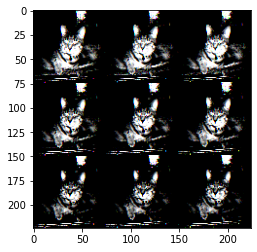

In [0]:
plt.imshow(np.reshape(images[0],(224,224,3)))

In [0]:
def vis(net, net_input):
    def f(net, net_input):
        t = net.shallow(net_input)
        t_1 = net.atblock_1(t)
        t_2 = net.atblock_2(t)
        t_ = torch.cat((t_1, t_2), 1)
        t_ = net.W(t_)
        t = t + t_
        return t
    sample_image_feature = f(net, sample_image.cuda())
    _sample_image_feature = F.upsample_nearest(
        sample_image_feature, 
        size=(224, 224), 
        scale_factor=None
    )
    _sample_image_feature = _sample_image_feature.cpu().squeeze().detach().numpy()
    _feature = np.zeros(_sample_image_feature[0].shape)
    _length = _sample_image_feature.shape[0]
    for i in range(_length):
        _feature += _sample_image_feature[i]
    _feature /= _length
    _sample_feature = np.array([_feature,_feature,_feature])
    _sample_feature = np.reshape(_sample_feature,(224,224,3))
    plt.imshow(_sample_feature)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2566: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


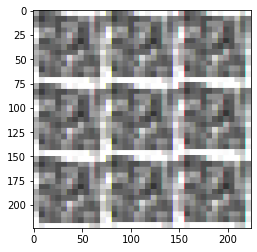

In [0]:
sample_image = images[0].unsqueeze(0)
vis(net, sample_image)